# Example of using The Module Formerly Known as KDE and Asy_peakbag
This is a notebook showing a rough draft of the replacement module for KDE and Asy_peakbag, which is currently WIP on the PBjam-dev branch.

We'll start by importing the modeID sampler (Should the name be changed?)

In [1]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO

We'll also use the IO module to load the PSD. This is a new module that contains all I/O related matters, saving/loading/downloading etc. The largest part of this is wrapping the various lightkurve steps to getting a PSD. However it now also stores lightkurve search results so that cached data are loaded more quickly. TODO: this is probably not necessary any longer, it's pretty fast these days.

The IO.psd class also normalizes the PSD consistently (Parseval). This is important since we're relying on the mode and background heights from the prior sample.

In [2]:
psd = IO.psd('KIC10963065', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq

s = psd.powerdensity 

No cached search results, searching MAST
Loading fits files from cache.


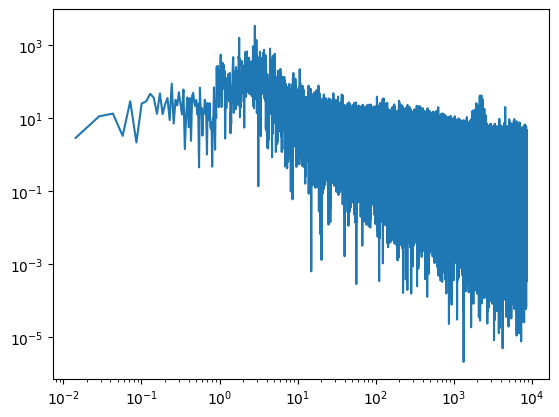

In [3]:
import matplotlib.pyplot as plt
plt.loglog(f, s)

In [4]:
obs = {'numax': (2204, 100),
       'dnu'  : (103.2, 0.54),
       'teff' : (6140, 77),
       'bp_rp': (0.70026, 0.05),
       } 

## Initialize the sampler
We can now initialize the sampler class. This requires specifying the number of orders `Np` (previously `norders`) to include in the model. For MS stars you can pick whatever you want, but once you go above 10 the p-mode asymptotic relation is usually not a great model, so the mode ID may be worse for the very high/low frequency modes. For more evolved stars, it's important to have a good number of radial orders, this tends to make it easier to find a good solution for the parameters involved in the mixed mode calculations, something like 7-9 is often good.

We also set the number of targets (`Npca`) to draw from the prior sample to construct covariance matrix for the DR, and the number of dimensions (`PCAdims`) to use in the sampling. Note that since we use a two-step approach, where we first identify the l=2,0 pairs, and then the l=1 modes, it's useful to supply a list of two values for each. If you supply a single value, it will be used for both steps.  

In [15]:
Np = 9

Npca = [20, 300]

PCAdims = [6, 5]
 
M = modeIDsampler(f[::5], s[::5], obs, 
                  N_p=Np, Npca=Npca, PCAdims=PCAdims, 
                  priorpath=IO.get_priorpath(), 
                  freqLimits=[obs['numax'][0]-1000, obs['numax'][0]+1000] )

Note that for this particular star, which is bright and has many years of observations, doing a mode ID on the full spectrum is probably overkill. So we've downsampled the spectrum by a factor of 5, and limited the model to $\nu_{max}\pm1000\,\mu$Hz. Runtime should be on the order of a few minutes, but for a full spectrum it may take significantly longer. 

## Run Dynesty
Time to run! You can optionally run with the dynamic sampler enabled, but it probably won't do you much good and take an order of magnitude longer.

In [16]:
M()

18119it [05:12, 58.04it/s, +600 | bound: 179 | nc: 1 | ncall: 534140 | eff(%):  3.508 | loglstar:   -inf < -25565.941 <    inf | logz: -25595.789 +/-  0.226 | dlogz:  0.001 >  0.609]


Not enough prior samples for mixed model. Using the asymptotic model.


1618it [00:05, 295.65it/s, +150 | bound: 48 | nc: 1 | ncall: 30417 | eff(%):  5.841 | loglstar:   -inf < -14516.316 <    inf | logz: -14525.191 +/-  0.222 | dlogz:  0.001 >  0.159]
4461it [00:12, 351.36it/s, +150 | bound: 171 | nc: 1 | ncall: 95806 | eff(%):  4.820 | loglstar:   -inf < -14516.278 <    inf | logz: -14525.190 +/-  0.204 | dlogz:  0.000 >  0.000]


In [17]:
M.result

{'summary': {'dnu': array([1.03123808e+02, 4.08677897e-02]),
  'numax': array([2197.9475451 ,    2.36199595]),
  'eps_p': array([1.29295487, 0.00841709]),
  'd02': array([8.57349265, 0.09511606]),
  'alpha_p': array([9.31140629e-04, 7.79675625e-05]),
  'env_width': array([225.66443594,   5.99216059]),
  'env_height': array([3.18757619, 0.15964542]),
  'mode_width': array([1.63761015, 0.02330771]),
  'teff': array([6066.27743118,   10.28914384]),
  'bp_rp': array([0.71329136, 0.00340252]),
  'H1_nu': array([2323.65022281,   76.05961634]),
  'H1_exp': array([4.28300288, 0.113469  ]),
  'H_power': array([839.33889191,  15.65694604]),
  'H2_nu': array([559.20637642,   7.85021054]),
  'H2_exp': array([4.04669475, 0.1271997 ]),
  'H3_power': array([ 983.87266626, 3149.24597356]),
  'H3_nu': array([2.43085301, 2.42652075]),
  'H3_exp': array([3.73931903, 0.70442637]),
  'shot': array([0.72442547, 0.00596994]),
  'nurot_e': array([0.95254716, 0.04967278]),
  'inc': array([1.24053004, 0.1708660

## Plot model samples
Time to plot some of the posterior samples

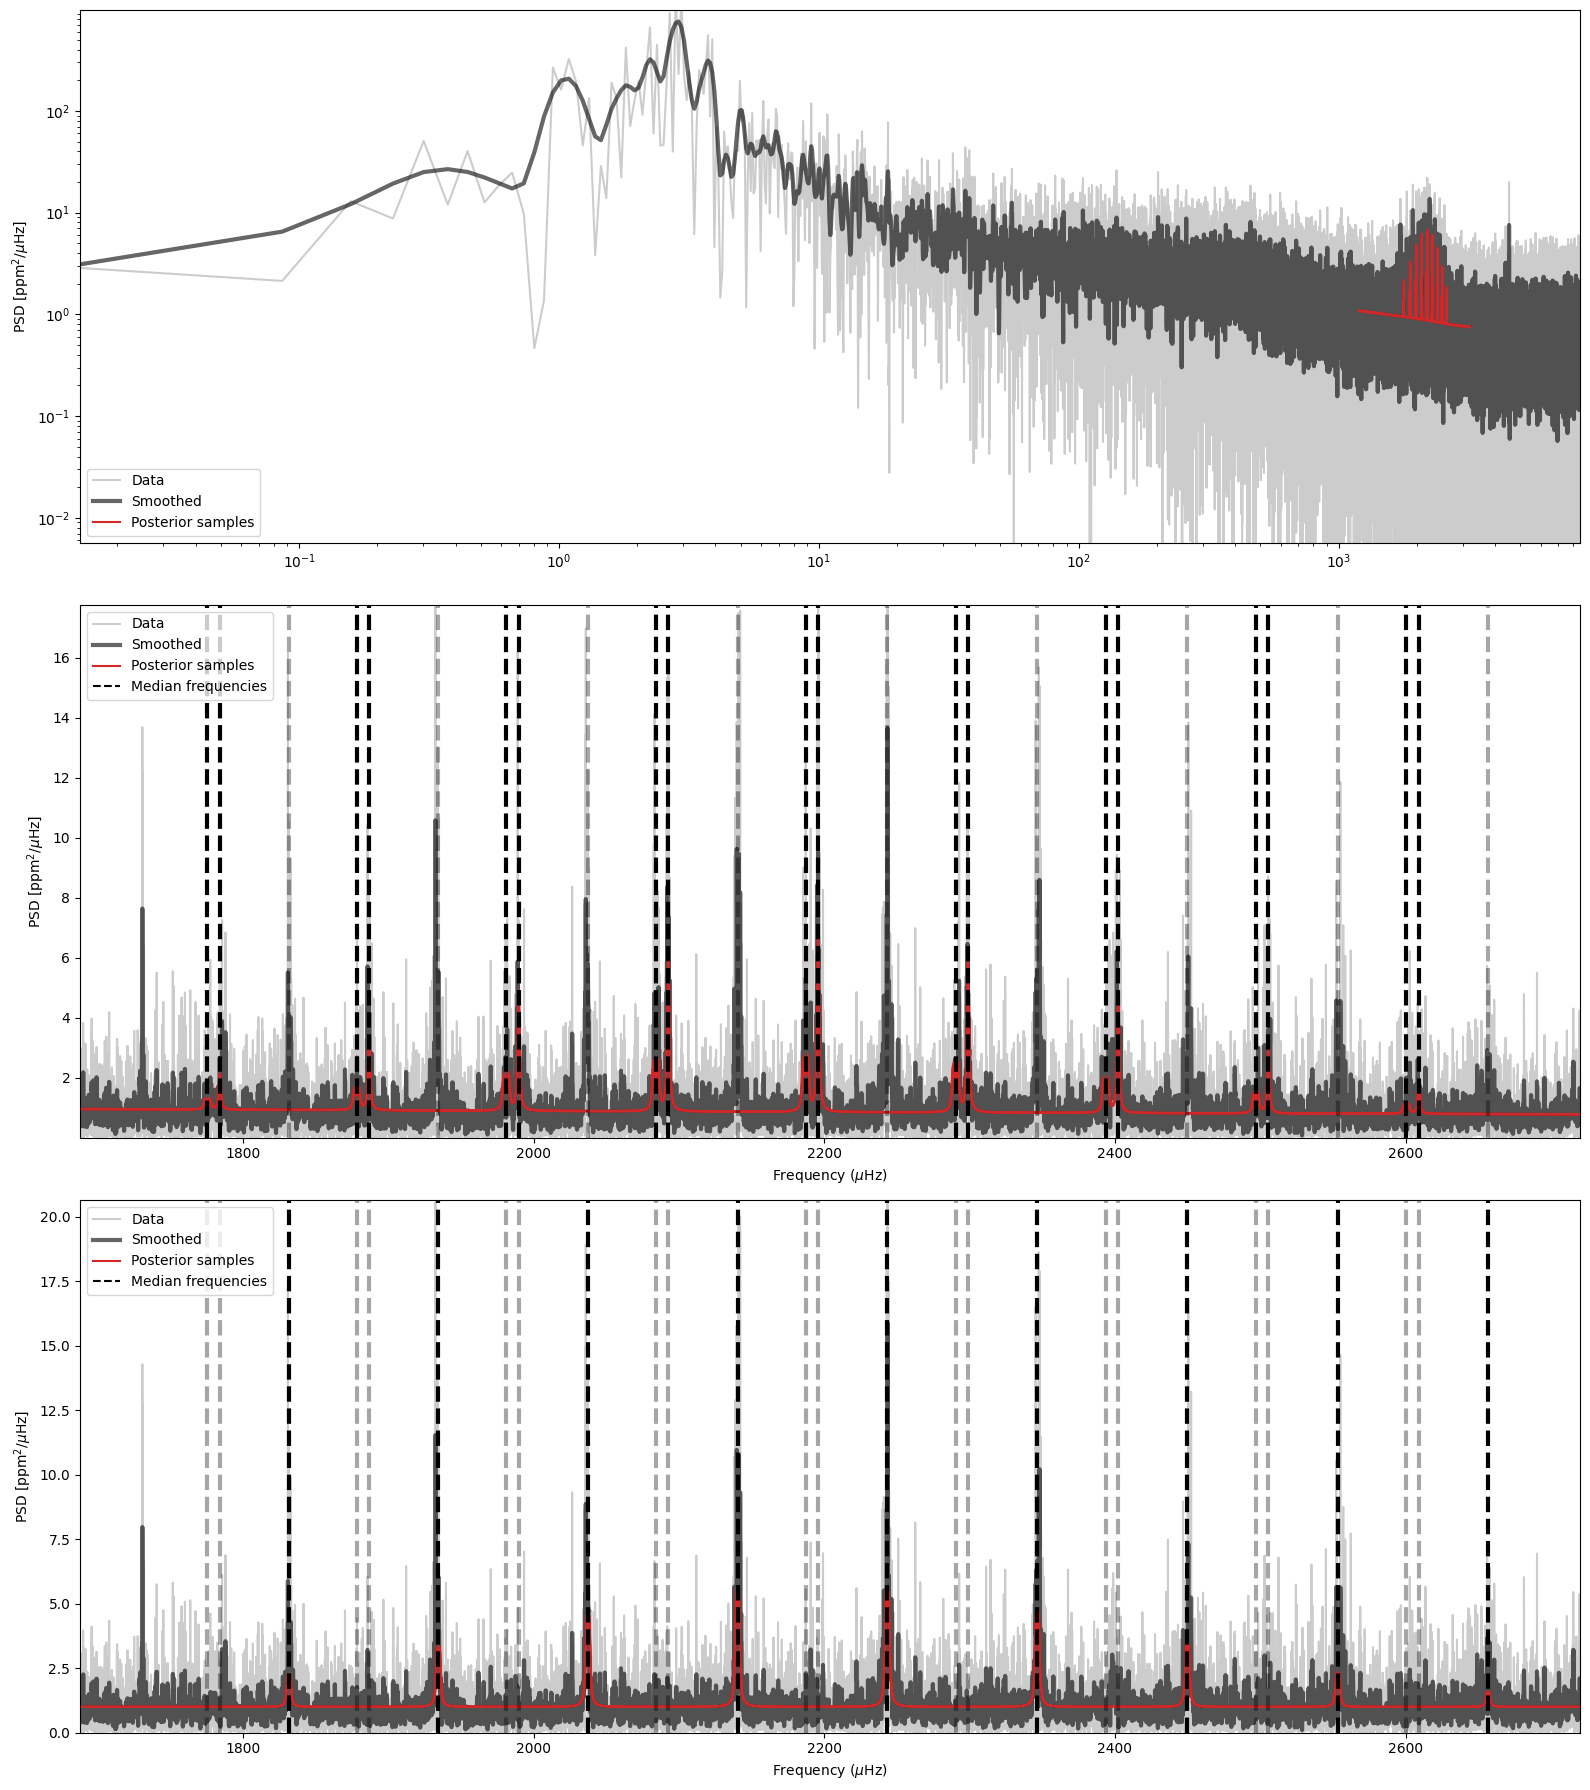

In [18]:
M.spectrum(stage='posterior');

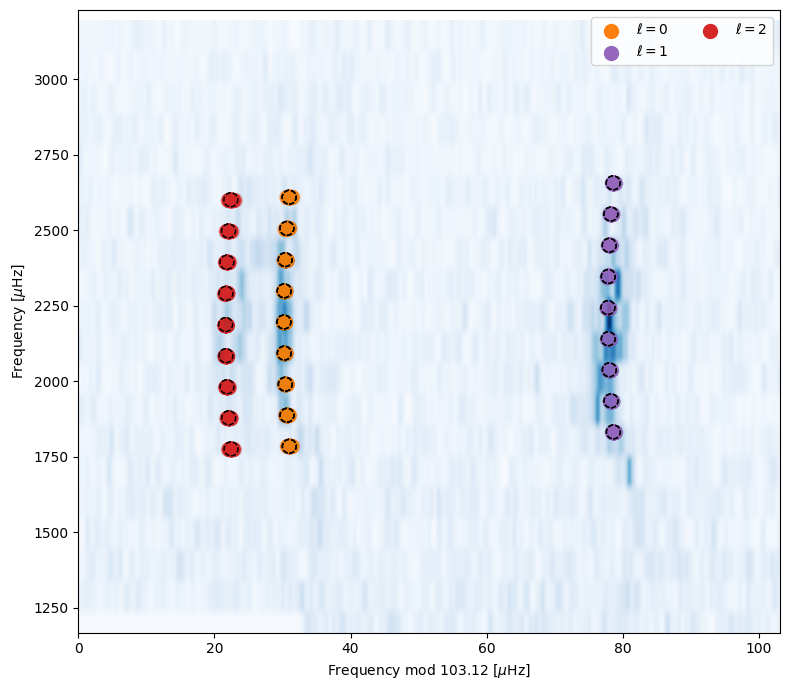

In [19]:
M.echelle(stage='posterior');

TODO: the prior plots don't work so well yet.